<a href="https://colab.research.google.com/github/nilaynishant/AIMLTutorial/blob/main/05_svm_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# run this only if you have not installed the requried packages
!pip install -q rasterio
!pip install -q gitpython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.0 MB/s eta 0:00:00


In [7]:
import os
import geopandas as gpd
import pandas as pd
import rasterio
import git

repo_url = 'https://github.com/nilaynishant/AIMLTutorial.git'  # set the URL of the repository
repo_dir = 'https://github.com/nilaynishant/AIMLTutorial/tree/main/Data'  # set the path to the local repository directory
if not os.path.exists('https://github.com/nilaynishant/AIMLTutorial/tree/main/Data'):
  git.Repo.clone_from(repo_url, repo_dir)
# variables
# Note: labels should be always last column with name "labels"
# Note: Make sure input labels shapefile and input raster have same CRS, otherwise code will not run

# input files
raster_loc = '/content/https:/github.com/nilaynishant/AIMLTutorial/tree/main/Data/Data/Sentinel2_Agartala.tif'
points_loc = '/content/https:/github.com/nilaynishant/AIMLTutorial/tree/main/Data/Data/Training.gpkg'
lulc_name = ['Vegetation', 'Builtup', 'Water', 'Agriculture','Fallow']



def get_features(raster_path, shapefile_path):
    # Load the raster data
    with rasterio.open(raster_path) as src:
        # Load the point data shapefile
        points = gpd.read_file(shapefile_path)

        # List to collect data
        data = []

        # Iterate through each point in the GeoDataFrame
        for _, point in points.iterrows():
            # Sample the raster at the point coordinates
            for val in src.sample([(point.geometry.x, point.geometry.y)]):
                # Prepare the record containing the point properties and raster values
                record = point.to_dict()
                # Update record with raster values; assuming raster has multiple bands
                record.update({f'Band_{i+1}_value': val[i] for i in range(len(val))})
                data.append(record)

        # Convert the list of dictionaries to a DataFrame
        return pd.DataFrame(data)

# Specify the path to your raster and shapefile
raster_path = raster_loc
shapefile_path = points_loc

# Extract the features and display as a DataFrame
df_features = get_features(raster_path, shapefile_path)
df_features

x = df_features.iloc[:,2:]
X = x.values
y = df_features.iloc[:,0]
Y = y.values


import sklearn
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, stratify = Y)

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

X_train Shape: (35, 4)
X_test Shape: (16, 4)
y_train Shape: (35,)
y_test Shape:(16,)


In [4]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
cName = 'SVM'
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

clf_pred = clf.predict(X_test)

# Accuracy assessment

Accuracy SVM: 25.0
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.33      0.33      0.33         3
           3       0.33      0.33      0.33         3
           4       0.50      0.50      0.50         4
           5       0.00      0.00      0.00         3

    accuracy                           0.25        16
   macro avg       0.23      0.23      0.23        16
weighted avg       0.25      0.25      0.25        16

Confusion Matrix RF: 
 [[0 1 1 0 1]
 [1 1 0 0 1]
 [1 1 1 0 0]
 [1 0 0 2 1]
 [0 0 1 2 0]]


Text(45.74999999999999, 0.5, 'Actual')

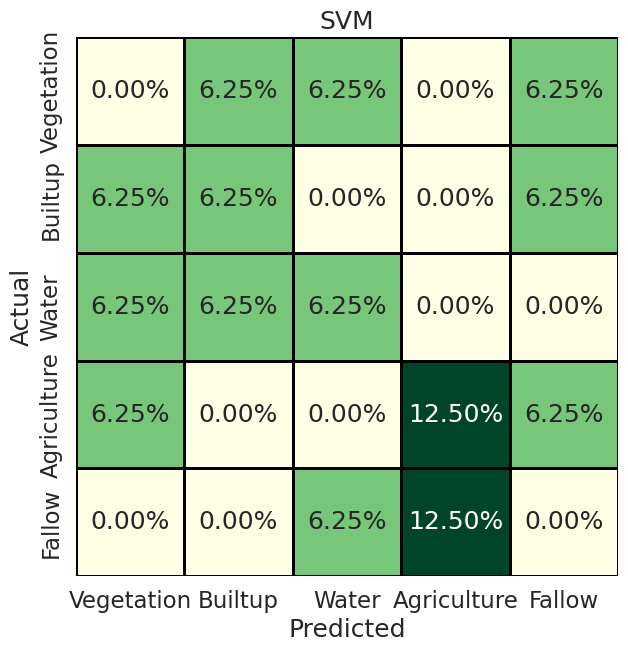

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import rasterio as rio
print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(f'../figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

In [12]:
%%time
cName = 'SVM'
exp_name = f'lulc_{cName}.tif'


img = rasterio.open(raster_loc)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, 4)
print('reshaped full data shape  for prediction: ',img_n.shape)
metadata = img.meta
height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')


pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')

img_reshape = pred_full.reshape(height, width)

out_raster = rasterio.open(exp_name,'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}.................')

Height: 1938
Width: 2202
Bands: 4

reshaped full data shape  for prediction:  (4267476, 4)
Prediction Done, now exporting raster 

Map saved SVM.................
CPU times: user 11.5 s, sys: 197 ms, total: 11.7 s
Wall time: 13.5 s
